# Week 3 — Regularization, Overfitting, Model Selection

Mini-project: Predict student exam pass/fail using a small synthetic dataset.

This notebook walks step-by-step through data creation, training a baseline and regularized logistic regression models, cross-validation, and evaluation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

np.random.seed(1)
plt.style.use('seaborn-whitegrid')

C:\Users\Hamza\AppData\Local\Temp\ipykernel_864\2184397238.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
# Generate synthetic dataset
n_samples = 1500
rng = np.random.RandomState(1)

hours_studied = rng.normal(loc=5, scale=2.5, size=n_samples)
attendance = rng.beta(a=5, b=1.5, size=n_samples)
prev_grade = rng.normal(loc=65, scale=15, size=n_samples)
sleep_hours = rng.normal(loc=7, scale=1.2, size=n_samples)
assignments_done = rng.binomial(n=10, p=0.8, size=n_samples) / 10.0

noise_feat1 = rng.normal(size=n_samples)
noise_feat2 = rng.uniform(size=n_samples)

X = np.vstack([hours_studied, attendance, prev_grade, sleep_hours, assignments_done, noise_feat1, noise_feat2]).T
coef = np.array([0.8, 1.5, 0.04, 0.1, 1.0, 0.2, -0.1])
intercept = -2.5
logits = X.dot(coef) + intercept
probs = 1.0 / (1.0 + np.exp(-logits))
y = (rng.rand(n_samples) < probs).astype(int)

columns = ['hours_studied','attendance','prev_grade','sleep_hours','assignments_done','noise_feat1','noise_feat2']
df = pd.DataFrame(X, columns=columns)
df['pass'] = y
df.head()

,hours_studied,attendance,prev_grade,sleep_hours,assignments_done,noise_feat1,noise_feat2,pass
0,9.060863,0.903727,60.310453,4.628370,0.8,-0.693269,0.725813,1
1,3.470609,0.473886,67.091773,5.594864,0.8,1.352575,0.942240,1
2,3.679571,0.595084,51.808460,7.637307,0.8,-1.810888,0.051846,1
3,2.317578,0.594924,37.927000,7.456449,0.8,-0.828882,0.203379,1
4,7.163519,0.806790,74.440553,8.865552,0.8,1.182747,0.046745,1


In [3]:
print('Class balance:')
print(df['pass'].value_counts(normalize=True))

df.describe().T

Class balance:
pass
1    0.989333
0    0.010667
Name: proportion, dtype: float64


,count,mean,std,min,25%,50%,75%,max
hours_studied,1500.0,5.129514,2.488444,-2.883394,3.503931,5.130272,6.797224,14.896507
attendance,1500.0,0.770646,0.157465,0.140843,0.670163,0.799581,0.895720,0.999432
prev_grade,1500.0,64.968408,15.217677,15.577124,55.005388,65.457112,74.769134,125.402736
sleep_hours,1500.0,7.027594,1.180841,2.612272,6.221765,6.997222,7.841932,11.335932
assignments_done,1500.0,0.796667,0.122905,0.400000,0.700000,0.800000,0.900000,1.000000
noise_feat1,1500.0,0.032120,1.002474,-3.310843,-0.646620,0.038732,0.731081,3.145369
noise_feat2,1500.0,0.496510,0.290340,0.000715,0.237669,0.486202,0.746549,0.999244
pass,1500.0,0.989333,0.102762,0.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
# Train / test split and scaling
X = df.drop(columns=['pass']).values
y = df['pass'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('Train size:', X_train.shape[0], 'Test size:', X_test.shape[0])

Train size: 1050 Test size: 450


In [5]:
# Baseline logistic regression (effectively no regularization)
from sklearn.linear_model import LogisticRegression

baseline = LogisticRegression(C=1e6, penalty='l2', solver='lbfgs', max_iter=2000)
baseline.fit(X_train, y_train)

y_pred = baseline.predict(X_test)
try:
    y_proba = baseline.predict_proba(X_test)[:,1]
except Exception:
    y_proba = None

print('Baseline test metrics:')
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, zero_division=0))
print('Recall:', recall_score(y_test, y_pred, zero_division=0))
print('F1:', f1_score(y_test, y_pred, zero_division=0))
if y_proba is not None:
    print('ROC AUC:', roc_auc_score(y_test, y_proba))

Baseline test metrics:
Accuracy: 0.9888888888888889
Precision: 0.9888888888888889
Recall: 1.0
F1: 0.9944134078212291
ROC AUC: 0.9456179775280898


In [6]:
# GridSearchCV for L2 and L1 regularization
param_grid = {'C': np.logspace(-4,4,9)}

l2_gs = GridSearchCV(LogisticRegression(penalty='l2', solver='lbfgs', max_iter=2000), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
l2_gs.fit(X_train, y_train)

l1_gs = GridSearchCV(LogisticRegression(penalty='l1', solver='saga', max_iter=5000), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
l1_gs.fit(X_train, y_train)

print('L2 best C:', l2_gs.best_params_['C'])
print('L1 best C:', l1_gs.best_params_['C'])

L2 best C: 0.1
L1 best C: 0.1


In [7]:
# Cross-validation on training set (StratifiedKFold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scoring = ['accuracy','precision','recall','f1','roc_auc']

models = {
    'baseline': baseline,
    'l2': l2_gs.best_estimator_,
    'l1': l1_gs.best_estimator_
}

for name, model in models.items():
    cv_res = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    print(f"\n{name} (train CV mean)")
    for metric in scoring:
        print(f"  {metric}: {np.mean(cv_res['test_'+metric]):.3f}")


baseline (train CV mean)
  accuracy: 0.989
  precision: 0.990
  recall: 0.999
  f1: 0.994
  roc_auc: 0.842

l2 (train CV mean)
  accuracy: 0.990
  precision: 0.990
  recall: 1.000
  f1: 0.995
  roc_auc: 0.841

l1 (train CV mean)
  accuracy: 0.990
  precision: 0.990
  recall: 1.000
  f1: 0.995
  roc_auc: 0.910



Test set metrics:

baseline
  accuracy: 0.989
  precision: 0.989
  recall: 1.000
  f1: 0.994
  roc_auc: 0.946

l2
  accuracy: 0.989
  precision: 0.989
  recall: 1.000
  f1: 0.994
  roc_auc: 0.954

l1
  accuracy: 0.989
  precision: 0.989
  recall: 1.000
  f1: 0.994
  roc_auc: 0.934


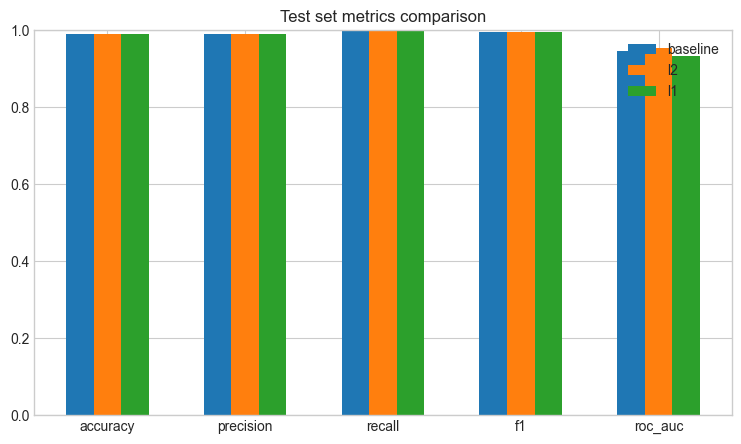

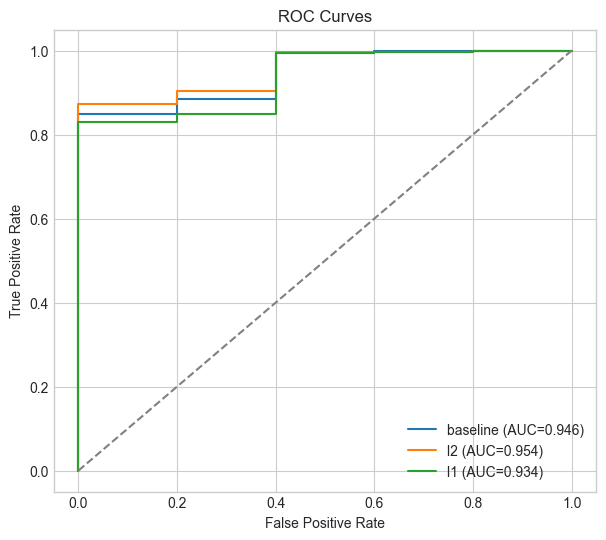


Best model by ROC AUC on test: l2

Confusion matrix:
[[  0   5]
 [  0 445]]


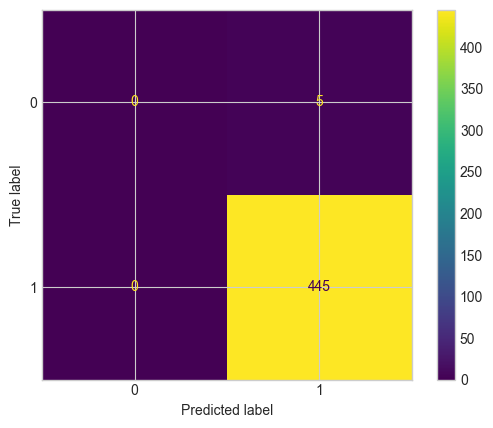

In [8]:
# Evaluate on test and plot results
metrics = {}
roc_data = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    try:
        y_proba = model.predict_proba(X_test)[:,1]
    except Exception:
        y_proba = None
    m = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
    }
    if y_proba is not None:
        m['roc_auc'] = roc_auc_score(y_test, y_proba)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_data[name] = (fpr, tpr, m['roc_auc'])
    else:
        m['roc_auc'] = np.nan
    metrics[name] = m

print('\nTest set metrics:')
for name, m in metrics.items():
    print(f"\n{name}")
    for k,v in m.items():
        print(f"  {k}: {v:.3f}")

# Plot metrics bar
metric_names = ['accuracy','precision','recall','f1','roc_auc']
fig, ax = plt.subplots(figsize=(9,5))
width = 0.2
x = np.arange(len(metric_names))
for i,(name,m) in enumerate(metrics.items()):
    vals = [m[k] for k in metric_names]
    ax.bar(x + i*width, vals, width=width, label=name)
ax.set_xticks(x + width)
ax.set_xticklabels(metric_names)
ax.set_ylim(0,1)
ax.set_title('Test set metrics comparison')
ax.legend()
plt.show()

# Plot ROC
fig, ax = plt.subplots(figsize=(7,6))
for name,(fpr,tpr,auc) in roc_data.items():
    ax.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
ax.plot([0,1],[0,1],'--',color='gray')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves')
ax.legend()
plt.show()

# Confusion matrix for best model
best_name = max(roc_data.items(), key=lambda kv: kv[1][2])[0]
print('\nBest model by ROC AUC on test:', best_name)
from sklearn.metrics import ConfusionMatrixDisplay
best_model = models[best_name]

cmd = confusion_matrix(y_test, best_model.predict(X_test))
print('\nConfusion matrix:')
print(cmd)

ConfusionMatrixDisplay(confusion_matrix=cmd).plot()
plt.show()

### Notes

- This notebook demonstrates differences between a baseline (no regularization) and L1/L2 regularized logistic regression.
- L1 can produce sparse coefficients (feature selection), L2 shrinks coefficients.
- Use cross-validation and a hold-out test set to compare models fairly.

---

If you want, I can run the notebook here to verify outputs and show plots.

In [11]:
# Hardcoded inference example
# Define a test student with the same feature order used in the notebook
feature_names = ['hours_studied','attendance','prev_grade','sleep_hours','assignments_done','noise_feat1','noise_feat2']
# Change these values to test different students
test_values = [6.0, 0.95, 78.0, 7.0, 1.0, 0.0, 0.2]

X_manual = np.array(test_values).reshape(1, -1)
# Use the existing scaler from the notebook
X_manual_scaled = scaler.transform(X_manual)

# Use the previously-determined best model (best_model) from the notebook
try:
    prob = best_model.predict_proba(X_manual_scaled)[0, 1]
except Exception:
    prob = float('nan')

pred = best_model.predict(X_manual_scaled)[0]

print('Test student features:')
for n, v in zip(feature_names, test_values):
    print(f"  {n}: {v}")
print(f"\nPredicted probability of passing: {prob:.3f}")
print(f"Predicted class (1=pass, 0=fail): {pred}")

# Optional: show decision threshold comparison
threshold = 0.5
print(f"\nDecision threshold: {threshold}")
if not np.isnan(prob):
    print('Prediction: PASS' if prob >= threshold else 'Prediction: FAIL')
else:
    print('Probability not available for this model; predicted class shown instead.')

Test student features:
  hours_studied: 6.0
  attendance: 0.95
  prev_grade: 78.0
  sleep_hours: 7.0
  assignments_done: 1.0
  noise_feat1: 0.0
  noise_feat2: 0.2

Predicted probability of passing: 0.995
Predicted class (1=pass, 0=fail): 1

Decision threshold: 0.5
Prediction: PASS
